## HOMEWORK 4
## 1) Does basic house information reflect house's description?

In this part of the homework our task is to perform a clustering analysis of house announcements in Rome from Immobiliare.it. We will create two datasets by retrieving data from websites. Then, we will
implement two clustering methods and compare the results.

**Python Libraries:**

In [1]:
import time
import threading
import requests
from bs4 import BeautifulSoup
import re
import csv
import pandas as pd

# for the clustering part:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

# our external file:
import collect_data 

### **Scraping data**

As the first step, we are collecting the list of interesting urls, starting from the website:
https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1.

+ We are using the time.sleep function to prevent the websie blocking.
+ The implementation of "thread_find_links" function is located in the external file **collect_data.py**

In [ ]:
link_threads = []
for nr_page in range(1, 100):
    t = threading.Thread(target=collect_data.thread_find_links, args=("nr_page",))
    t.start()
    time.sleep(1)

+ We are saving collected links into **links.txt** file

In [64]:
print("The number of collected links: {}".format(len(link_threads)))

The number of collected links: 25974


In [ ]:
with open("links.txt", "w") as link_file:
    for url_ in link_threads:
        link_file.write(url_)

In [8]:
# Load data from link.txt 
with open("links.txt", "r") as link_file:
    link_threads = link_file.readlines()

+ We are iterating through collected links to retrieve and save data about flats. 
+ For this, we defined the fuction **threadExtract**. 
+ We applied the parallel programming by generating threads for each url. 

In [27]:
def threadExtract(url):
    """
    This function gets html content and scraps the interesting data
    Input: String: "url" 
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    scrapped_data = collect_data.scrap_data(soup)
    if scrapped_data != None:
        datawriter.writerow(scrapped_data)

+ The collected data are saved in **flat_data.txt** file.

In [33]:
# data_file = open("flat_data.txt", "w", encoding='utf-8')
headers = ["price", "locali", "superficie", "bagni", "piano", "description"]
datawriter = csv.writer(data_file)
datawriter.writerow(headers)

49

In [ ]:
def create_threads(from_, to_):
    for link_ in link_threads[from_ : to_]:
        try:
            threading.Thread(threadExtract(link_[:-1])).start() #-1 because we have "\n" in the end of a link
            time.sleep(3) #for non-blocking
        except Exception as e:
            print(e)
            failed_links.append(link_)

In [ ]:
# Run threads: 
for rep in range(0, 20000, 100):
    create_threads(from_= rep, to_ = rep+100)
data_file.close()

### Datasets

We are reading the **flat_data.txt** file content as dataframe.
Then, we are splitting the collected data into two separated dataframes:
+ **Information dataset** : [price, locali, superficie, bagni, piano]
+ **Description dataset** : [TFIDF matrix for descriptions]

In [37]:
data_frame = pd.read_csv("flat_data.txt")

In [38]:
len(data_frame)

10544

In [39]:
inf_dataset = data_frame[["price", "locali", "superficie", "bagni", "piano"]]
inf_dataset.head()

,price,locali,superficie,bagni,piano
0,1260000,5,225,2,4
1,245000,2,80,1,2
2,319000,3,114,1,1
3,630000,4,153,2,5
4,157000,3,68,1,1


+ In order to create the TFIDF matrix (Description Dataset), we defined the function **generate_tfidf_matrix**, which as an input takes the dataframe with column "description" for all announsments. The implementation is located in the external file **collect_data.py**

In [48]:
def generate_tfidf_matrix(data_frame[["description"]]):
    # code ...
    return tfidf_matrix
    
desc_dataset = data_frame[["description"]]
desc_dataset.head()

,description
0,In stabile signorile in Via Appia Nuov...
1,Rif: G118 - APPIA NUOVA STATUARIO Via ...
2,proponiamo in vendiata ampio e luminos...
3,Rif: 20141 - Appartamento composto da ...
4,Proponiamo la vendita di un trilocale ...


### Clustering

####  K-means++

This part consists of clustering the house announcements using K-means++ method. 
In order to choose the optimal number of clusters we used the Elbow-Method.

+ We are iterating through a different number of cluster "k"
+ Clusters are saved as an additional column in a dataframe

In [56]:
# INFORMATION DATASET

sse = {}
for k in range(1,4):
    kmeanModel = KMeans(n_clusters=k, max_iter=1000).fit(inf_dataset)
    # save clusters in df
    inf_dataset['clusters'+str(k)] = kmeanModel.labels_
    sse[k] = kmeanModel.inertia_ # check it

In [57]:
inf_dataset.head()

,price,locali,superficie,bagni,piano,clusters,clustersk,clusters1,clusters2,clusters3
0,1260000,5,225,2,4,2,1,0,1,1
1,245000,2,80,1,2,1,0,0,0,0
2,319000,3,114,1,1,1,0,0,0,0
3,630000,4,153,2,5,0,2,0,0,2
4,157000,3,68,1,1,1,0,0,0,0


+ According to the plot, the best values are..

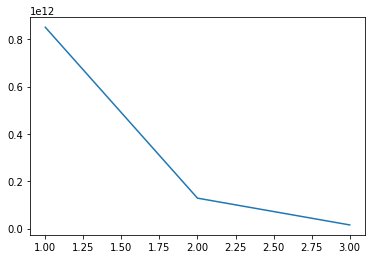

In [60]:
# plotting the elbow-method results
plt.figure()
plt.xlabel = "k - Number of clusters "  # TODO: Why we do not have titles? ??????
plt.ylabel = "SSE (Inertia)"
plt.title = "Plot of SSE for kmeans clustering"
plt.plot(list(sse.keys()), list(sse.values()))
plt.show()

In [61]:
# TODO: paste more code from HM4_Asia